In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit, minimize

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# read in our version of the SMARTS patterns
#  .. to make sure we're comparing the right things to each other
our_smarts = []
with open('ring_smarts_patterns.txt') as smarts_file:
    for line in smarts_file: # index   smarts
        index, smarts = line.split()
        our_smarts.append(smarts)

maxTorsions = len(our_smarts) # e.g. ignore pattern 0
print(f"Found {maxTorsions} torsion patterns")

Found 105 torsion patterns


In [3]:
# read the ETKDG patterns and fit parameters

smarts_list = [None] * maxTorsions
# keep the etkdg probabilities in a list for later use
etkdg_list = [None] * maxTorsions

# read in the torsion patterns
etkdg_file = "etkdg/torsionPreferences_smallRings.in"
with open(etkdg_file) as torsions:
    # skip the comments at the top
    for _ in range(10):
        next(torsions)
    pattern = 0
    for line in torsions:
        if "//" in line:
            continue
        chunk = line.split('"')[1][0:-2]  # -2 drops the '/n' at the end
        smarts = chunk.split()[0]
        function = chunk.split()[1:] # parts of the cosine fit
        #print(function)
        
        x = np.linspace(0, 360, 360)
        # build up the y potential in a loop
        y = np.zeros_like(x)
        for m in range(6):
            s = float(function[m*2])
            V = float(function[m*2+1])
            if np.abs(s) < 0.1:
                continue
            y = y + V*(1 + s*(np.cos((m+1) * np.pi * x / 180.0)))
        # now generate the Boltzmann probabilities
        e_min = np.min(y)
        kT = 0.593 # in kcal/mol
        prob = np.exp(-y / kT)

        # for debugging
        #plt.plot(x, prob)
        #plt.title(f"Pattern {pattern} = {smarts}")
        #plt.savefig(f"fit-figures/t{pattern}-etkdg.pdf")
        #plt.close()
        
        smarts_list[pattern] = smarts
        etkdg_list[pattern] = (prob / np.max(prob))
        pattern += 1

In [4]:
# define a function to get the histograms and bins
# put together a total histogram from all the subdirectories
dirs = ['cod-torsions', 'pqr-torsions', 'zinc-torsions', 'pubchemqc-torsions']

def get_binned(torsion, bin_size = 10):
    totals = np.full(360, 1.0e-6) # eliminate any zero values
    for dir in dirs:
        filename = f"{dir}/t{torsion}-rings-conf.txt"
        try:
            with open(filename) as f:
                slice = 0
                for line in f:
                    totals[slice] += float(line.rstrip())
                    slice += 1
        except FileNotFoundError:
            continue

    for angle in range(181, 360):
        mirror = 360 - angle
        sum = (totals[angle] + totals[mirror])
        totals[angle] = totals[mirror] = sum
        
    # bin the probabilities
    #  i.e. everything in the bin is averaged
    bins = int(len(totals) / bin_size) + 1 # first and last bins are half-sized
    binned = np.zeros_like(totals)
    left = 0
    for bin in range(bins):
        width = bin_size
        if bin == 0 or (left + width) > len(totals):
            width = int(bin_size / 2)
        right = left + width

        mean = np.mean(totals[left:right])
        if mean < 1.0e-6:
            mean = 1.0e-6 # avoid log(zero)
        binned[left:right] = mean
        left = right

    # normalize
    totals = totals / np.sum(totals)
    binned = binned / np.sum(binned)
    return totals, binned

In [5]:
# Standard ETKDG fit
# ETKDG uses V(1 + s*cos(mx)) for a potential energy
def etkdg(x, *args):
    count = int(len(args)/2)
    s_ = args[0::2]
    V_ = args[1::2]
    y = np.zeros_like(x)
    for m in range(count):
        s = s_[m]
        V = V_[m]
        y = y + V*(1 + s*(np.cos((m+1)*np.pi*x/180.0)))
    return y

# erase the file
fit_name = "cos-ring-fit.txt"
with open(fit_name, "w") as fits:
    fits.write("// cosine fits\n")

# r-squared of fit
cos_r2 = []
etkdg_r2 = []
    
for torsion in range(1, maxTorsions): 
    totals, binned = get_binned(torsion)
    degrees = np.linspace(0, 360, 360)

    # transform from probabilities to energies using Boltzmann statistics
    relative_energy = -0.593 * np.log(binned)

    # Use 6 terms (12 parameters) to fit using cosines (s, V)
    # could use np.ones but we might want to change the initial value
    terms = 6
    params = np.full(2*terms, 1.0)
    val, covariance = curve_fit(etkdg, degrees, relative_energy, p0=params)
    
    # energies if you want them    #plt.plot(degrees, relative_energy)
    #plt.plot(degrees, potential(degrees, *val))
    
    # plot the fitted probabilities vs. histograms
    plt.plot(degrees, binned, label='Binned Counts')
    fitted = etkdg(degrees, *val)
    prob = np.exp(-fitted / 0.593)
    plt.plot(degrees, prob, label='Fit')
    
    max_height = np.max(binned)
    
    # compare to ETKDG
    # .. caveat that the ETKDG numbering is not identical
    current_smarts = our_smarts[torsion]
    plt.title(f"Torsion {torsion}\n{current_smarts}")
    try:
        if current_smarts in smarts_list:
            index = smarts_list.index(current_smarts)
            plt.plot(degrees, max_height*etkdg_list[index], label='ETKDG Fit')
    except (IndexError, TypeError) as e:
        print(f"Missing ETKDG {torsion}")
    
    plt.xticks(np.linspace(0, 360, 7))
    plt.xlabel("Torsion (°)")
    plt.ylabel("Probability per 10° Bin")
    plt.xlim(0, 180)
    plt.legend()
    #plt.show()
    plt.savefig(f"fit-figures/t{torsion}-ring-cos.pdf")
    plt.close()
    
    # r-squared of fit
    cos_r2.append(np.corrcoef(binned, prob)[0, 1]**2)
    etkdg_r2.append(np.corrcoef(binned,max_height*etkdg_list[index])[0,1]**2)
    
    # append the smarts and fits
    with open(fit_name, "a") as fits:
        array = np.array2string(val, precision=3, separator=' ', max_line_width=255)
        fits.write(current_smarts + ' ' + array[1:-1] + '\n')

In [6]:
#  .. for some things, V(1 + s*cos())**2 seems to fit better
def varpot(x, *args):
    count = int(len(args)/2)
    s_ = args[0::2]
    V_ = args[1::2]
    y = np.zeros_like(x)
    for m in range(count):
        s = s_[m]
        V = V_[m]
        y = y + V*(1 + s*(np.cos((m+1)*np.pi*x/180.0))**2)
    return y

# erase the file
fit_name = "cos2-ring-fit.txt"
with open(fit_name, "w") as fits:
    fits.write("// cosine**2 fits\n")

# r-squared of fit
cos2_r2 = []
    
for torsion in range(1, maxTorsions): 
    totals, binned = get_binned(torsion)
    degrees = np.linspace(0, 360, 360)

    # transform from probabilities to energies using Boltzmann statistics
    relative_energy = -0.593 * np.log(binned)

    # Use 6 terms (12 parameters) to fit using cosines (s, V)
    # could use np.ones but we might want to change the initial value
    terms = 6
    params = np.full(2*terms, 1.0)
    val, covariance = curve_fit(varpot, degrees, relative_energy, p0=params, maxfev=100000)
    
    # energies if you want them    #plt.plot(degrees, relative_energy)
    #plt.plot(degrees, potential(degrees, *val))
    
    # plot the fitted probabilities vs. histograms
    plt.plot(degrees, binned, label='Binned Counts')
    fitted = varpot(degrees, *val)
    prob = np.exp(-fitted / 0.593)
    plt.plot(degrees, prob, label='Trig. Fit')
    
    max_height = np.max(binned)
    
    # compare to ETKDG
    # .. caveat that the ETKDG numbering is not identical
    current_smarts = our_smarts[torsion]
    plt.title(f"Torsion {torsion}\n{current_smarts}")
    try:
        if current_smarts in smarts_list:
            index = smarts_list.index(current_smarts)
            plt.plot(degrees, max_height*etkdg_list[index], label='ETKDG Fit')
    except (IndexError, TypeError) as e:
        print(f"Missing ETKDG {torsion}")
    
    plt.xticks(np.linspace(0, 360, 7))
    plt.xlabel("Torsion (°)")
    plt.ylabel("Probability per 10° Bin")
    plt.xlim(0, 180)
    plt.legend()
    #plt.show()
    plt.savefig(f"fit-figures/t{torsion}-ring-cos2.pdf")
    plt.close()
    
    # r-squared of fit
    cos2_r2.append(np.corrcoef(binned, prob)[0, 1]**2)
    
    # append the smarts and fits
    with open(fit_name, "a") as fits:
        array = np.array2string(val, precision=3, separator=' ', max_line_width=255)
        fits.write(current_smarts + ' ' + array[1:-1] + '\n')

In [7]:
# Compare with fitting a sum of X gaussians
# f(x) = a * exp( -\frac{(x - b)^2}{2c^2} )
def vargauss(x, *args):
    count = int(len(args)/3)
    # need center, width and scaling
    scale = args[0::3]
    center = args[1::3]
    width = args[2::3]
    y = np.zeros_like(x)
    for m in range(count):
        s = scale[m]
        c = center[m]
        w = width[m]
        y = y + s*np.exp(-(((x - c))/w)**2)
    return y

# we'll use scipy find_peaks to locate the centers of the Gaussians
from scipy.signal import find_peaks

# erase the file
fit_name = "gauss-ring-fit.txt"
with open(fit_name, "w") as fits:
    fits.write("// gaussian fits\n")

gauss_r2 = []
    
for torsion in range(1, maxTorsions): 
    degrees = np.linspace(0, 360, 360)
    totals, binned = get_binned(torsion)
    
    # inital parameters from fit_peaks
    temp = np.concatenate(([0],binned))
    peaks, _ = find_peaks(temp, distance=10, prominence=0.001)
    if binned[-1] > 0.001:
        peaks = np.concatenate((peaks, [360]))

    num_peaks = len(peaks)
    params = np.full(num_peaks*3, 10.0)
    for i in range(num_peaks):
        params[i*3] = 0.05 / float(num_peaks) # scale
        params[i*3 + 1] = peaks[i]
    
    # sometimes we try/except to go to smaller sets
    try:
        val, covariance = curve_fit(vargauss, degrees, binned, p0=params, maxfev=10000)
    except RuntimeError:
        #print(f"Trying 4 peaks {torsion}")
        
        # try fewer, smaller initial peaks
        num_peaks = 4
        params = np.full(num_peaks*3, 10.0)
        for i in range(num_peaks):
            params[i*3] = 0.05 / float(num_peaks) # scale
            params[i*3 + 1] = i * (360./float(num_peaks - 1)) # center

        try:
            val, covariance = curve_fit(vargauss, degrees, binned, p0=params, maxfev=100000)
        except RuntimeError:
            #print(f"Trying 3 peaks {torsion}")

            num_peaks = 3
            params = np.full(num_peaks*3, 15.0)
            for i in range(num_peaks):
                params[i*3] = 0.05 / float(num_peaks) # scale
                params[i*3 + 1] = i * (360./float(num_peaks - 1)) # center

            try:
                val, covariance = curve_fit(vargauss, degrees, binned, p0=params, maxfev=250000)
            except:
                print(f"Fit problem {torsion}")
                val = params # need to do manual fitting
    
    # probabilities vs. histograms
    plt.plot(degrees, binned, label='Binned Counts')
    fitted = vargauss(degrees, *val)
    plt.plot(degrees, fitted, label='Gaussian Fit')
        
    # compare to ETKDG
    # .. caveat that the ETKDG numbering is not identical
    current_smarts = our_smarts[torsion]
    plt.title(f"Torsion {torsion}\n{current_smarts}")
    try:
        if current_smarts in smarts_list:
            index = smarts_list.index(current_smarts)
            
            max_height = np.max(binned)
            plt.plot(degrees, max_height*etkdg_list[index], label='ETKDG Fit')
    except (IndexError, TypeError) as e:
        print(f"Missing ETKDG {torsion}")
    
    plt.xticks(np.linspace(0, 360, 7))
    plt.xlabel("Torsion (°)")
    plt.ylabel("Probability per 10° Bin")
    plt.xlim(0, 180)
    plt.legend()
    plt.savefig(f"fit-figures/t{torsion}-ring-gauss.pdf")
    plt.close()
    
    # r-squared of fit
    gauss_r2.append(np.corrcoef(binned, fitted)[0, 1]**2)
    
    # append the smarts and fits
    with open(fit_name, "a") as fits:
        array = np.array2string(val, precision=3, separator=' ', max_line_width=255)
        fits.write(current_smarts + ' ' + array[1:-1] + '\n')

Fit problem 7
Fit problem 8
Fit problem 9
Fit problem 10
Fit problem 56
Fit problem 60
Fit problem 95


In [8]:
# Use this for the histograms

sns.set_context("notebook", font_scale=1.5)

ETKDG v1 0.031318573317907716


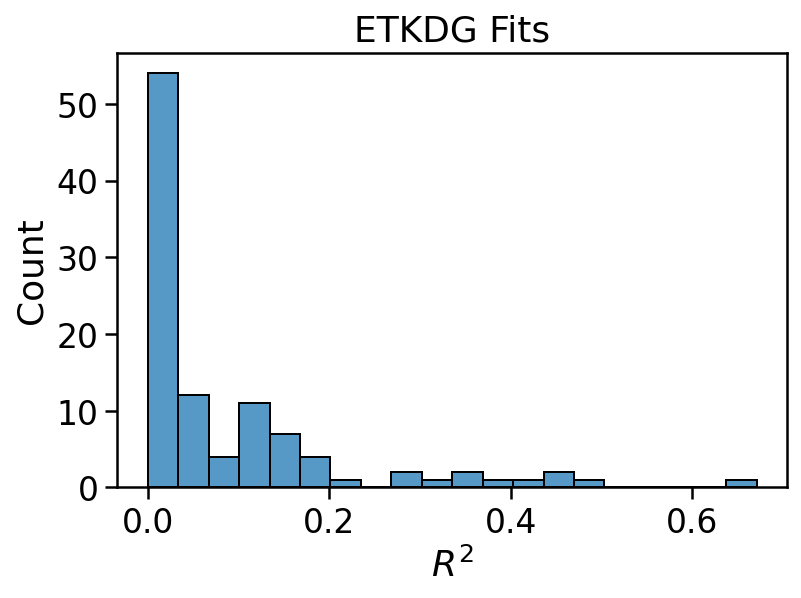

In [9]:
print("ETKDG v1", np.median(etkdg_r2))
sns.histplot(etkdg_r2, bins=20)
plt.title("ETKDG Fits")
plt.xlabel("$R^2$")
plt.savefig(f"figures/etkdg-ring-histogram.pdf")
plt.show()

Our cosine fits 0.7326172400082845


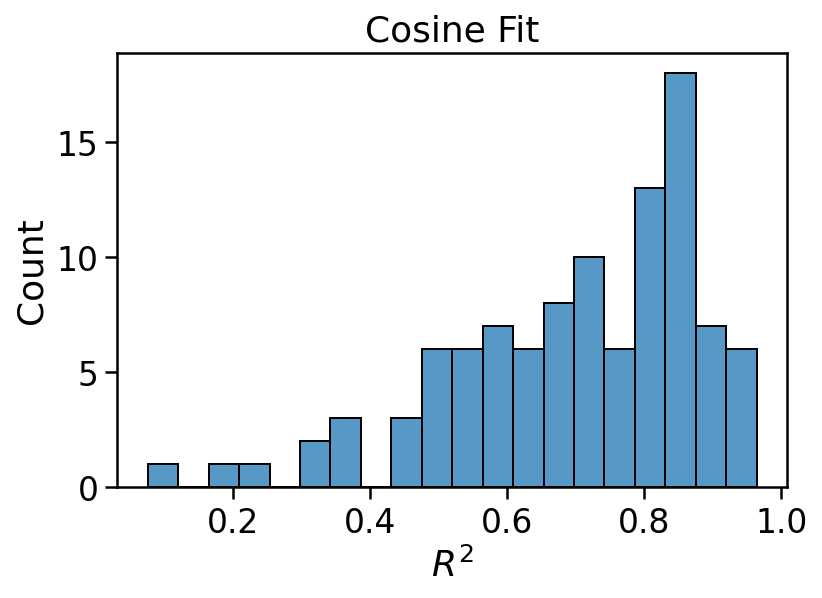

In [10]:
print("Our cosine fits", np.median(cos_r2))
a = sns.histplot(cos_r2, bins=20)
plt.title("Cosine Fit")
plt.xlabel("$R^2$")
plt.savefig(f"figures/cosine-ring-histogram.pdf")
plt.show()

Cos^2 fit 0.27353140711794377


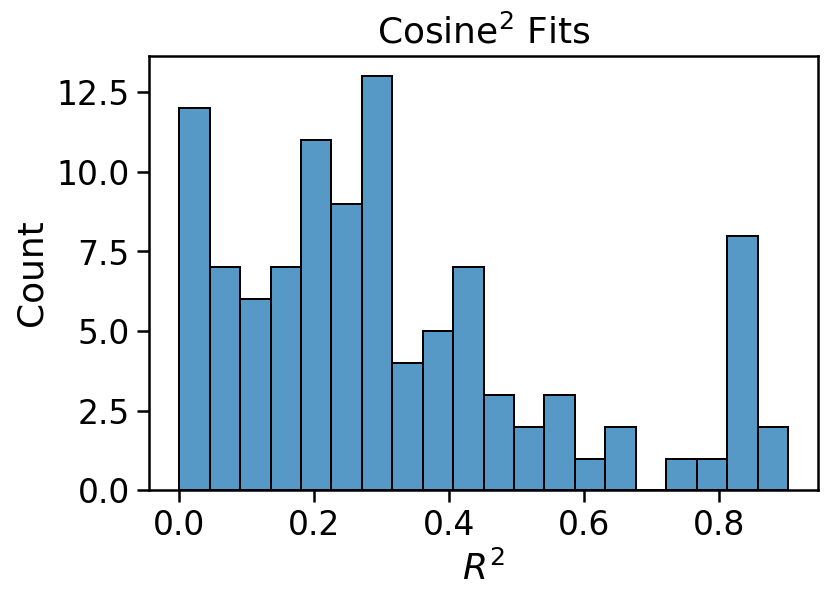

In [11]:
print("Cos^2 fit", np.median(cos2_r2))
sns.histplot(cos2_r2, bins=20)
plt.title("Cosine$^2$ Fits")
plt.xlabel("$R^2$")
plt.show()

Gaussian 0.9112322047067335


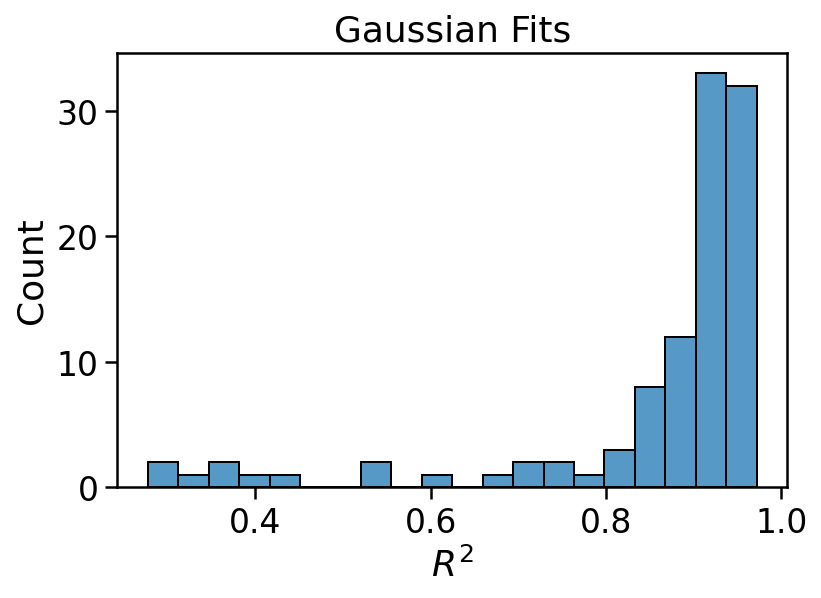

In [12]:
print("Gaussian", np.median(gauss_r2))
sns.histplot(gauss_r2, bins=20)
plt.title("Gaussian Fits")
plt.xlabel("$R^2$")
plt.savefig(f"figures/gaussian-ring-histogram.pdf")
plt.show()